## Introduction

Price prediction is beneficial for Perfect Competition, a triple-win market. 
We'll mension here the best benefits as well as the cons that Air bnb can get from this analysis and predictions:

#### Benefits

- Hosts have an intuitive opportunity to compare their services and amenities with competitors. As competition intensifies, the overall service quality and market - size of the rental housing market will be improved.
- Price prediction models are reliable references for data-driven decision-making. With price suggestions from Airbnb, hosts can make different business strategies.
- Airbnb users have more choices at lower price or higher quality.
- Airbnb can grow faster including attract more users and hosts, leading to opertional and data center cost reduction and profit growth.

#### Cons

- The model accuracy will be lower than expected due to missing some essential features.

- The transaction data: The datasets did not contain transaction data. We don't know if the listings were booked or just unavailable. We will explore how to find the confirmed orders under the Exploratory Data Analysis part.
- The search engine data: The datasets do not contain searching histories.

Although we don't have the transaction data, and the number of reviews did not play an essential role in price prediction, I'm sure such features will influence the rank on the search engine.

Airbnb uses machine learning models to intensify the competition. They can provide Price Tips, Smart Pricing, and improvement suggestions to the host. As a host, you can combine the models and good strategies to maximize your competitiveness and profit. Airbnb users are also benefited from the perfect competition.

Currently, Airbnb has at least two Machine Learning models for price prediction. They are both for hosts:

#### Price Tips
Price Tips: Price tips are automated nightly price recommendations that you can choose to save. They are based on the type and location of your listing, the season, demand, and other factors. Even if you use price tips, you always control your price and can override the tips at any time. — Refered from Airbnb.

#### Smart Pricing
Smart Pricing: Smart Pricing lets you set your prices to automatically go up or down based on changes in demand for listings like yours. You are always responsible for your price, so Smart Pricing is controlled by other pricing settings you choose, and you can adjust nightly prices any time. Smart Pricing is based on the type and location of your listing, the season, demand, and other factors. — Refered from Airbnb.

###### The following features are defined by Airbnb:

- How many people are searching for listings like yours
- The dates they’re looking at
- Whether other listings are getting booked
- Your listing’s best qualities
- Your neiborhood: To calculate pricing based on location, Smart Pricing looks at whether your listing is in a city - neighborhood, a suburb, or a more spread-out area.
- Review rate: The number and quality of your reviews is another key factor in Smart Pricing.
- Completed trips: If you honor most confirmed reservations, your prices can go higher within the minimum and maximum range you set.
- Your listing' amenities: Wi-fi, washer/dryer, and air conditioning are especially important, but Smart Pricing looks at all your amenities.

#### What is Calendar?
The calendar contains three types of price:
- Base price set by the host.
- One time special price for event set by the host.
- Price based on the demand, which is automatically set by Smart Pricing.

#### Dependencies

In [53]:
# Statistics
import pandas as pd
import numpy as np
import math as mt

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

px.defaults.width = 1200
px.defaults.height = 800
# plotly.io Settings for both plotly.graph_objects and plotly.express
pio.templates.default = "plotly_white" # "plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"
"""
pio.kaleido.scope.default_format = 'svg'
pio.kaleido.scope.default_scale = 1
"""
# installing
! pip install --upgrade category_encoders
! pip install lightgbm
! pip install optuna

# Data Preprocessing - Standardization, Encoding, Imputation
from sklearn.preprocessing import StandardScaler # Standardization
from sklearn.preprocessing import Normalizer # Normalization
from sklearn.preprocessing import OneHotEncoder # One-hot Encoding
from sklearn.preprocessing import OrdinalEncoder # Ordinal Encoding
from category_encoders import MEstimateEncoder # Target Encoding
from sklearn.preprocessing import PolynomialFeatures # Create Polynomial Features
from sklearn.impute import SimpleImputer # Imputation

# Exploratory Data Analysis - Feature Engineering
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA

# Modeling - ML Pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Modeling - Algorithms
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
#from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# ML - Evaluation
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# ML - Tuning
import optuna
#from sklearn.model_selection import GridSearchCV

# Settings
# Settings for Seaborn
sns.set_theme(context='notebook', style='ticks', palette="bwr_r", font_scale=0.7, rc={"figure.dpi":240, 'savefig.dpi':240})

## Datasets

- listings: The listings' information including nightly price (base price).
- reviews: All of the past reviews for each listing.
- calendar: The availability for each listing with the base price, special price, or smart price.

In [54]:
import os
kaggle_project = 'seattle'
# Import dataset from local directory './data' or from Kaggle
data_dir = ('./data/201601' if os.path.exists('data') else f'/kaggle/input/{kaggle_project}')

# print all files in data_dir
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Import three datasets
reviews = pd.read_csv('reviews.csv')
calendar = pd.read_csv('calendar.csv')
listings = pd.read_csv('listings.csv')

## Cross-Validation KFold

In [55]:
def generate_listings_kfold():
    # Mark the train dataset with kfold = 5
    listings = pd.read_csv('listings.csv')
    if os.path.exists(f'{data_dir}/listings_kfold.csv'):
        os.remove(f'{data_dir}/listings_kfold.csv')
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (train_idx, valid_idx) in enumerate(kf.split(X=listings)):
        listings.loc[valid_idx, "kfold"] = fold

    listings.to_csv(f'listings_kfold.csv', index=False)

generate_listings_kfold()
listings = pd.read_csv(f'listings_kfold.csv')

In [56]:
# After assigning kfold
# If error, run the above function then re-load listings_kfold.csv
listings.loc[:, ['id', 'kfold']].head()

id  kfold
0   241032    0.0
1   953595    4.0
2  3308979    2.0
3  7421966    3.0
4   278830    4.0

## Load Metadata

The medata data includes Label, Data Type, Description, ML, Reason:

- Label: the column name
- Data Type: the data type of the column
- Description: the label usage based on our observation from Airbnb
- ML: is it useful for Machine Learning
     * 0: cannot be used for ML since it is meaningless, or it's hard to measuring (e.g. listing photos)
     * 1: must be used for ML due to the official description by Airbnb
     * 2: possible be used for ML due to our assessment
- Reason: why the label can or cannot be used for ML (may empty)

In [57]:
# Define sheet id and base url
sheet_id = "1M_qah-ym6O8vDcSmoKAP-lbZRPHUey83R_DJaW3LXfs"
base_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet="

# Load metadata for three datasets
listings_metadata = pd.read_csv(base_url+"listings")
calendar_metadata = pd.read_csv(base_url+"calendar")
reviews_metadata = pd.read_csv(base_url+"reviews")

## ETL Pipeline
The ETL pipeline provides data transformation and formatting. Thus, we can calculate the data and perform machine learning with the correct data format.

In [58]:
class ETL_pipeline:
    def __init__(self, data_frame):
        self.df = data_frame
    
    # Data type transformation
    def _transformation(self, data_frame):
        df = data_frame
        # Convert dollar columns from object to float
        # Remove '$' and ','
        dollar_cols = ['price', 'weekly_price', 'monthly_price', 'extra_people', 'security_deposit', 'cleaning_fee']
        for dollar_col in dollar_cols:
            df[dollar_col] = df[dollar_col].replace('[\$,]', '', regex=True).astype(float)
        # Convert dollar columns from object to float
        # Remove '%'
        percent_cols = ['host_response_rate', 'host_acceptance_rate']
        for percent_col in percent_cols:
            df[percent_col] = df[percent_col].replace('%', '', regex=True).astype(float)

        # Replace the following values in property_type to Unique space due to small sample size
        unique_space = ["Barn",
        "Boat",
        "Bus",
        "Camper/RV",
        "Treehouse",
        "Campsite",
        "Castle",
        "Cave",
        "Dome House",
        "Earth house",
        "Farm stay",
        "Holiday park",
        "Houseboat",
        "Hut",
        "Igloo",
        "Island",
        "Lighthouse",
        "Plane",
        "Ranch",
        "Religious building",
        "Shepherd’s hut",
        "Shipping container",
        "Tent",
        "Tiny house",
        "Tipi",
        "Tower",
        "Train",
        "Windmill",
        "Yurt",
        "Riad",
        "Pension",
        "Dorm",
        "Chalet"]            
        df.property_type = df.property_type.replace(unique_space, "Unique space", regex=True)

        # Convert 't', 'f' to 1, 0
        tf_cols = ['host_is_superhost', 'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification']
        for tf_col in tf_cols:
            df[tf_col] = df[tf_col].replace('f', 0, regex=True)
            df[tf_col] = df[tf_col].replace('t', 1, regex=True)
        
        return df
    
    # Parse listings
    def parse_listings(self):
        """Parse listings.
        """
        df = self.df
        df = self._transformation(df)
        return df
    
    def parse_reviews(self):
        """Parse reviews.
        """
        df = self.df
        df.date = pd.to_datetime(df.date)
        return df
    
    # Parse calendar
    def parse_calender(self):
        """Paser calendar.
        """
        df = self.df
        # Convert date from object to datetime
        df.date = pd.to_datetime(df.date)
        # Convert price from object to float
        # Convert '$' and ',' to ''
        df.price = df.price.replace('[\$,]', '', regex=True).astype(float)
        
        # Convert 't', 'f' to 1, 0
        df['available'] = df['available'].replace('f', 0, regex=True)
        df['available'] = df['available'].replace('t', 1, regex=True)

        return df

In [59]:
# e.g. Before parsing
listings.loc[:4, ['id', 'price']]

id    price
0   241032   $85.00
1   953595  $150.00
2  3308979  $975.00
3  7421966  $100.00
4   278830  $450.00

In [60]:
listings = ETL_pipeline(listings).parse_listings()
reviews = ETL_pipeline(reviews).parse_reviews()
calendar = ETL_pipeline(calendar).parse_calender()

In [61]:
# e.g. After parsing
listings.loc[:4, ['id', 'price']]

id  price
0   241032   85.0
1   953595  150.0
2  3308979  975.0
3  7421966  100.0
4   278830  450.0

## ML Pipeline
EDA_demand calculates the demand for each listing from csv reviews.
ML Pipeline imputes and transforms data for Machine Learning.

In [62]:
class EDA_demand:
    def __init__(self):
        pass
    
    def reviews_rate_vs_unavailability(self, period=30):
        """Calculate the booked listing from file calendar.

        Args:
            period (int): Positive integer. Default is 30.

        Returns:
            Pandas DataFrame.
        """
        assert (0 < period <= 365) & isinstance(period, int), "period must be an integer and greater than 0"
        self.period = period
        
        #
        # Calculate review rate & unavailability
        #

        # reviews Rate: review / days
        """
        SELECT 
            listing_id, 
            COUNT(listing_id) / DATEDIFF(20160104+1, MIN(date)) AS reviews_per_day
        FROM reviews
        GROUP BY listing_id
        """
        # Extract the first reviews date for each listing
        func = lambda df: pd.Series({'first_day': df.date.min()})
        df_reviews_per_day = pd.DataFrame(reviews.groupby('listing_id').apply(func))
        # Define last scraped date
        last_scraped = listings.last_scraped.unique()[0]
        last_scraped = pd.Timestamp(last_scraped)
        df_reviews_per_day['last_day'] = last_scraped + pd.DateOffset(days=1)
        # Calculate the datediff
        df_reviews_per_day['datediff'] = df_reviews_per_day.last_day - df_reviews_per_day.first_day
        df_reviews_per_day['datediff'] = df_reviews_per_day['datediff'].dt.days
        # Calculate the reviews Rate
        df_reviews_per_day['reviews_per_day'] = reviews.groupby('listing_id').size() / df_reviews_per_day['datediff']

        """
        SELECT listing_id, SUM(IF(available = 0, 1, 0))
        FROM calendar
        WHERE DATEDIFF(date, 20160104) <= period
        GROUP BY listing_id
        """
        last_day = last_scraped + pd.DateOffset(days=period-1)
        filter = calendar.date <= (last_day)
        func = lambda df: pd.Series({f'unavailability_{period}_unscaled': sum(df.available == 0)}) # Scaling available to day scale
        df_unavailability = pd.DataFrame(calendar[filter].groupby('listing_id').apply(func))
        df_unavailability[f'unavailability_{period}'] = df_unavailability[f'unavailability_{period}_unscaled'] / period
        #df_unavailability['first_day'] = last_scraped
        #df_unavailability['last_day'] = last_day
        self.df_unavailability = df_unavailability
        
        # Join two tables
        df_unavailability_reviews = df_unavailability.join(df_reviews_per_day, how='left')
        df_unavailability_reviews.reviews_per_day.fillna(value=0, inplace=True)
        #df_unavailability_reviews.loc[:, [f'unavailability_{period}_unscaled', f'unavailability_{period}', 'reviews_per_day']]
        
        # Find outliers (unavailable rather than booked)
        # Extrat quantiles
        reviews_rate_25 = df_unavailability_reviews.reviews_per_day.quantile(q=0.25, interpolation='higher')
        unavailability_75 = df_unavailability_reviews[f'unavailability_{period}'].quantile(q=0.75, interpolation='higher')
        # Low reviews rate: 0.010376
        filter1 = df_unavailability_reviews.reviews_per_day < reviews_rate_25
        # High unavailability: 0.660274
        filter2 = df_unavailability_reviews[f'unavailability_{period}'] > unavailability_75

        outliers = df_unavailability_reviews[filter1 & filter2]
        df_unavailability_reviews['demand'] = df_unavailability_reviews[f'unavailability_{period}_unscaled']
        df_unavailability_reviews.loc[outliers.index, 'demand'] = period - df_unavailability_reviews.loc[outliers.index, 'demand']
        
        self.outliers = outliers
        self.df_unavailability_reviews = df_unavailability_reviews
        
        return self.df_unavailability_reviews
    
    def plot(self, outliers=True):
        """Display plot or describe the relationship between reviews per day and unavailabilities to filter the outliers of demand.
        
        Args:
            outlier (bool): Display outliers or not. Default is True
            
        Returns:
            Plotly instance
        """
        period = self.period
        
        if outliers is True:
            idx = self.outliers.index
            df = self.df_unavailability_reviews.loc[idx, :]
        else:
            idx = self.df_unavailability_reviews.index.drop(self.outliers.index)
            df = self.df_unavailability_reviews.loc[idx, :]

        assert df.shape[0] > 0, "No records"

        fig = px.line(df, 
                      x=df.index, 
                      y=[f'unavailability_{period}', 'reviews_per_day'],
                      color_discrete_sequence=['rgb(71, 92, 118, 0.9)', 'rgb(250, 211, 102, 0.9)']
                     )
        fig.update_layout(title=f'Unavailability per day vs. reviews per day<br>Outliers', xaxis_title='index', yaxis_title='Rate')

        return fig

In [63]:
class ML_pipeline:
    """ML Pipeline for listings.
    """
    def __init__(self, data_frame, features, target, days=365):
        """
        
        Args:
            data_frame (Pandas DataFrame): listings.
            features (list): The Machine Learning features.
            target (str): price
            days (int): The days after 2016-01-04 for calculating demand.
        """
        import warnings
        warnings.filterwarnings("ignore") # ignore target encoding warnings
        
        # Get demand
        demand = EDA_demand().reviews_rate_vs_unavailability(days)
        # The index will change to id
        data_frame = data_frame.set_index('id').join(demand['demand'], how='inner')
        
        features.append(target)
        data_frame = data_frame[features]
        
        # Encode amenities
        data_frame = self._encode_amentities(data_frame)
        data_frame.pop('amenities')
        
        self.data_frame = data_frame
        
    # encode amentities
    def _encode_amentities(self, data_frame):
        # Replace amenities from {}" to ''
        data_frame.amenities.replace('[{}"]', '', regex=True, inplace=True)
        # Split amenities with ,
        amenities = data_frame.amenities.str.split(',', expand=True)
        
        """All amenities
        '24-Hour Check-in',
        'Air Conditioning',
        'Breakfast',
        'Buzzer/Wireless Intercom',
        'Cable TV',
        'Carbon Monoxide Detector',
        'Cat(s)',
        'Dog(s)',
        'Doorman',
        'Dryer',
        'Elevator in Building',
        'Essentials',
        'Family/Kid Friendly',
        'Fire Extinguisher',
        'First Aid Kit',
        'Free Parking on Premises',
        'Gym',
        'Hair Dryer',
        'Hangers',
        'Heating',
        'Hot Tub',
        'Indoor Fireplace',
        'Internet',
        'Iron',
        'Kitchen',
        'Laptop Friendly Workspace',
        'Lock on Bedroom Door',
        'Other pet(s)',
        'Pets Allowed',
        'Pets live on this property',
        'Pool',
        'Safety Card',
        'Shampoo',
        'Smoke Detector',
        'Smoking Allowed',
        'Suitable for Events',
        'TV',
        'Washer',
        'Washer / Dryer',
        'Wheelchair Accessible',
        'Wireless Internet'
        """

        # For each col, extract the unique amenities
        amenities_uniques = []
        for col in amenities.columns:
            amenities_uniques += list(amenities[col].unique())

        # Remove the duplicate values
        amenities_uniques = set(amenities_uniques)
        amenities_uniques.remove('')
        amenities_uniques.remove(None)
        # Only two rows have Washer / Dryer, and they both have washer and dryer
        amenities_uniques.remove('Washer / Dryer')
        # When 'Pets live on this property' is True, one or more from 'Cat(s)', 'Dog(s)', 'Other pet(s)' will appear

        # Encoding amenities
        amenities_enc = pd.DataFrame()
        for amenity in amenities_uniques:
            amenities_enc[amenity] = data_frame.amenities.str.contains(amenity, regex=False)

        # Rename the columns with prefix amenity_
        amenities_enc.columns = [f"amenity_{col}" for col in amenities_enc.columns]
        
        # Concat encoded amenities and data_frame
        data_frame = pd.concat([data_frame, amenities_enc], axis=1)

        return data_frame

    def _imputation(self, X_train, X_valid, y_train, y_valid):
        X_train, X_valid, y_train, y_valid = X_train.copy(), X_valid.copy(), y_train.copy(), y_valid.copy()
        
        # Zero imputation
        # Reason:
        zero_imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
        zero_features = ['reviews_per_month', 'host_response_rate', 'host_is_superhost', 'security_deposit', 'cleaning_fee']
        X_train_zero_imp = pd.DataFrame(zero_imp.fit_transform(X_train[zero_features]))
        X_valid_zero_imp = pd.DataFrame(zero_imp.transform(X_valid[zero_features]))
        X_train_zero_imp.columns = zero_features
        X_valid_zero_imp.columns = zero_features
        X_train_zero_imp.index = X_train.index
        X_valid_zero_imp.index = X_valid.index
        X_train_zero_imp = X_train_zero_imp.astype(float)
        X_valid_zero_imp = X_valid_zero_imp.astype(float)
        
        # Mean imputation
        # Reason:
        mean_imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        mean_features = ['host_acceptance_rate', 'review_scores_accuracy', 'review_scores_checkin', 
                         'review_scores_value', 'review_scores_location', 'review_scores_cleanliness', 
                         'review_scores_communication', 'review_scores_rating']
        X_train_mean_imp = pd.DataFrame(mean_imp.fit_transform(X_train[mean_features]))
        X_valid_mean_imp = pd.DataFrame(mean_imp.transform(X_valid[mean_features]))
        X_train_mean_imp.columns = mean_features
        X_valid_mean_imp.columns = mean_features
        X_train_mean_imp.index = X_train.index
        X_valid_mean_imp.index = X_valid.index
        X_train_mean_imp = X_train_mean_imp.astype(float)
        X_valid_mean_imp = X_valid_mean_imp.astype(float)
        
        # Mode imputation
        # Reason: 
        mode_imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        mode_features = ['bathrooms', 'bedrooms', 'beds', 'property_type']
        X_train_mode_imp = pd.DataFrame(mode_imp.fit_transform(X_train[mode_features]))        
        X_valid_mode_imp = pd.DataFrame(mode_imp.transform(X_valid[mode_features]))
        X_train_mode_imp.columns = mode_features
        X_valid_mode_imp.columns = mode_features
        X_train_mode_imp.index = X_train.index
        X_valid_mode_imp.index = X_valid.index
        X_train_mode_imp[['bathrooms', 'bedrooms', 'beds']] = X_train_mode_imp[['bathrooms', 'bedrooms', 'beds']].astype(int)
        X_valid_mode_imp[['bathrooms', 'bedrooms', 'beds']] = X_valid_mode_imp[['bathrooms', 'bedrooms', 'beds']].astype(int)
        
        # Replace the unimputated columns
        for feature in zero_features:
            X_train[feature] = X_train_zero_imp[feature]
            X_valid[feature] = X_valid_zero_imp[feature]
        
        for feature in mean_features:
            X_train[feature] = X_train_mean_imp[feature]
            X_valid[feature] = X_valid_mean_imp[feature]

        for feature in mode_features:
            X_train[feature] = X_train_mode_imp[feature]
            X_valid[feature] = X_valid_mode_imp[feature]
        
        return X_train, X_valid, y_train, y_valid
    
    def _one_hot_encoding(self, X_train, X_valid, y_train, y_valid):
        X_train, X_valid, y_train, y_valid = X_train.copy(), X_valid.copy(), y_train.copy(), y_valid.copy()
        
        oe_enc_features = ['cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification', 
                               'neighbourhood_group_cleansed', 'property_type', 'instant_bookable', 'room_type', 'bed_type']
        
        oe = OrdinalEncoder()
        X_train[oe_enc_features] = oe.fit_transform(X_train[oe_enc_features])
        X_valid[oe_enc_features] = oe.transform(X_valid[oe_enc_features])
    
        return X_train, X_valid, y_train, y_valid

    def _target_encoding(self, X_train, X_valid, y_train, y_valid):
        X_train, X_valid, y_train, y_valid = X_train.copy(), X_valid.copy(), y_train.copy(), y_valid.copy()
        
        target_enc_features = ['cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification', 
                               'neighbourhood_group_cleansed', 'property_type', 'instant_bookable', 'room_type', 'bed_type']
        
        # Create the encoder instance. Choose m to control noise.
        target_enc = MEstimateEncoder(cols=target_enc_features, m=5.0)
        X_train = target_enc.fit_transform(X_train, y_train)
        X_valid = target_enc.transform(X_valid)
        
        return X_train, X_valid, y_train, y_valid
    
    def getData(self, kfold, target_encoding=True):
        data_frame = self.data_frame.copy()
        
        # Split train and valid
        X_train = data_frame[data_frame.kfold != kfold]
        X_valid = data_frame[data_frame.kfold == kfold]
        y_train = X_train.pop('price')
        y_valid = X_valid.pop('price')
        
        # Imputation
        X_train, X_valid, y_train, y_valid = self._imputation(X_train, X_valid, y_train, y_valid)
        
        # Target Encoding
        if target_encoding:
            X_train, X_valid, y_train, y_valid = self._target_encoding(X_train, X_valid, y_train, y_valid)
        else:
            X_train, X_valid, y_train, y_valid = self._one_hot_encoding(X_train, X_valid, y_train, y_valid)
        
        return X_train, X_valid, y_train, y_valid

In [64]:
# e.g. Before ML pipeline
listings.loc[:2, ['id', 'neighbourhood_group_cleansed', 'property_type', 'amenities', 'price']]

id neighbourhood_group_cleansed property_type  \
0   241032                   Queen Anne     Apartment   
1   953595                   Queen Anne     Apartment   
2  3308979                   Queen Anne         House   

                                                                                                                                                                                                                                                                                             amenities  \
0                                                                                                                                                                                   {TV,"Cable TV",Internet,"Wireless Internet","Air Conditioning",Kitchen,Heating,"Family/Kid Friendly",Washer,Dryer}   
1                                                  {TV,Internet,"Wireless Internet",Kitchen,"Free Parking on Premises","Buzzer/Wireless Intercom",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector","First Aid Kit","Safety Card","Fire Extinguisher",Essentials}   
2  {TV,"Cable TV",Internet,"Wireless Internet","Air Conditioning",Kitchen,"Free Parking on Premises","Pets Allowed","Pets live on this property",Dog(s),Cat(s),"Hot Tub","Indoor Fireplace",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector",Essentials,Shampoo}   

   price  
0   85.0  
1  150.0  
2  975.0

In [65]:
# e.g. After ML pipeline
features = ['host_acceptance_rate', 'neighbourhood_group_cleansed', 'property_type', 'room_type',
            'bathrooms', 'bedrooms', 'beds', 'bed_type', 'number_of_reviews', 'review_scores_rating',
            'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
            'review_scores_location', 'review_scores_value', 'reviews_per_month', 'host_response_rate', 'host_is_superhost', 
            'accommodates', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 
            'maximum_nights', 'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', 
            'require_guest_phone_verification', 'amenities', 'demand', 'kfold']

ml_pipeline = ML_pipeline(data_frame=listings, features=features, target='price')
X_train, X_valid, y_train, y_valid = ml_pipeline.getData(kfold=0, target_encoding=True) # perform target encoding
X = pd.concat([X_train, X_valid], axis=0)
y = pd.concat([y_train, y_valid])
X['price'] = y

In [66]:
X.loc[[241032, 953595, 3308979], ['neighbourhood_group_cleansed', 'property_type', 'price']]

neighbourhood_group_cleansed  property_type  price
241032                     151.102994     123.397576   85.0
953595                     151.102994     123.397576  150.0
3308979                    151.102994     132.880445  975.0

In [67]:
# e.g. After ML pipeline
X.loc[[241032, 953595, 3308979], 'amenity_Elevator in Building':]

amenity_Elevator in Building  amenity_Gym  amenity_Iron  \
241032                          False        False         False   
953595                          False        False         False   
3308979                         False        False         False   

         amenity_Breakfast  amenity_Internet  amenity_Washer  \
241032               False              True            True   
953595               False              True            True   
3308979              False              True            True   

         amenity_Suitable for Events  amenity_Other pet(s)  amenity_TV  \
241032                         False                 False        True   
953595                         False                 False        True   
3308979                        False                 False        True   

         amenity_Hot Tub  ...  amenity_Cable TV  amenity_Shampoo  \
241032             False  ...              True            False   
953595             False  ...             False            False   
3308979             True  ...              True             True   

         amenity_Pets live on this property  amenity_Free Parking on Premises  \
241032                                False                             False   
953595                                False                              True   
3308979                                True                              True   

         amenity_Buzzer/Wireless Intercom  amenity_Kitchen  \
241032                              False             True   
953595                               True             True   
3308979                             False             True   

         amenity_Smoking Allowed  amenity_Essentials  amenity_Pets Allowed  \
241032                     False               False                 False   
953595                     False                True                 False   
3308979                    False                True                  True   

         price  
241032    85.0  
953595   150.0  
3308979  975.0  

[3 rows x 28 columns]

## EDA and Feature Engineering

#### Heatmap 1.0

Pandas .corr() method calculates the Pearson correlation coefficient between every two features. And heatmap shows the relationship more clearly. Here, accommodates, bathrooms, bedrooms, beds, security_deposit, cleaning_fee, guests_included, extra_people have relatively higher correlation coefficient than other features with price.

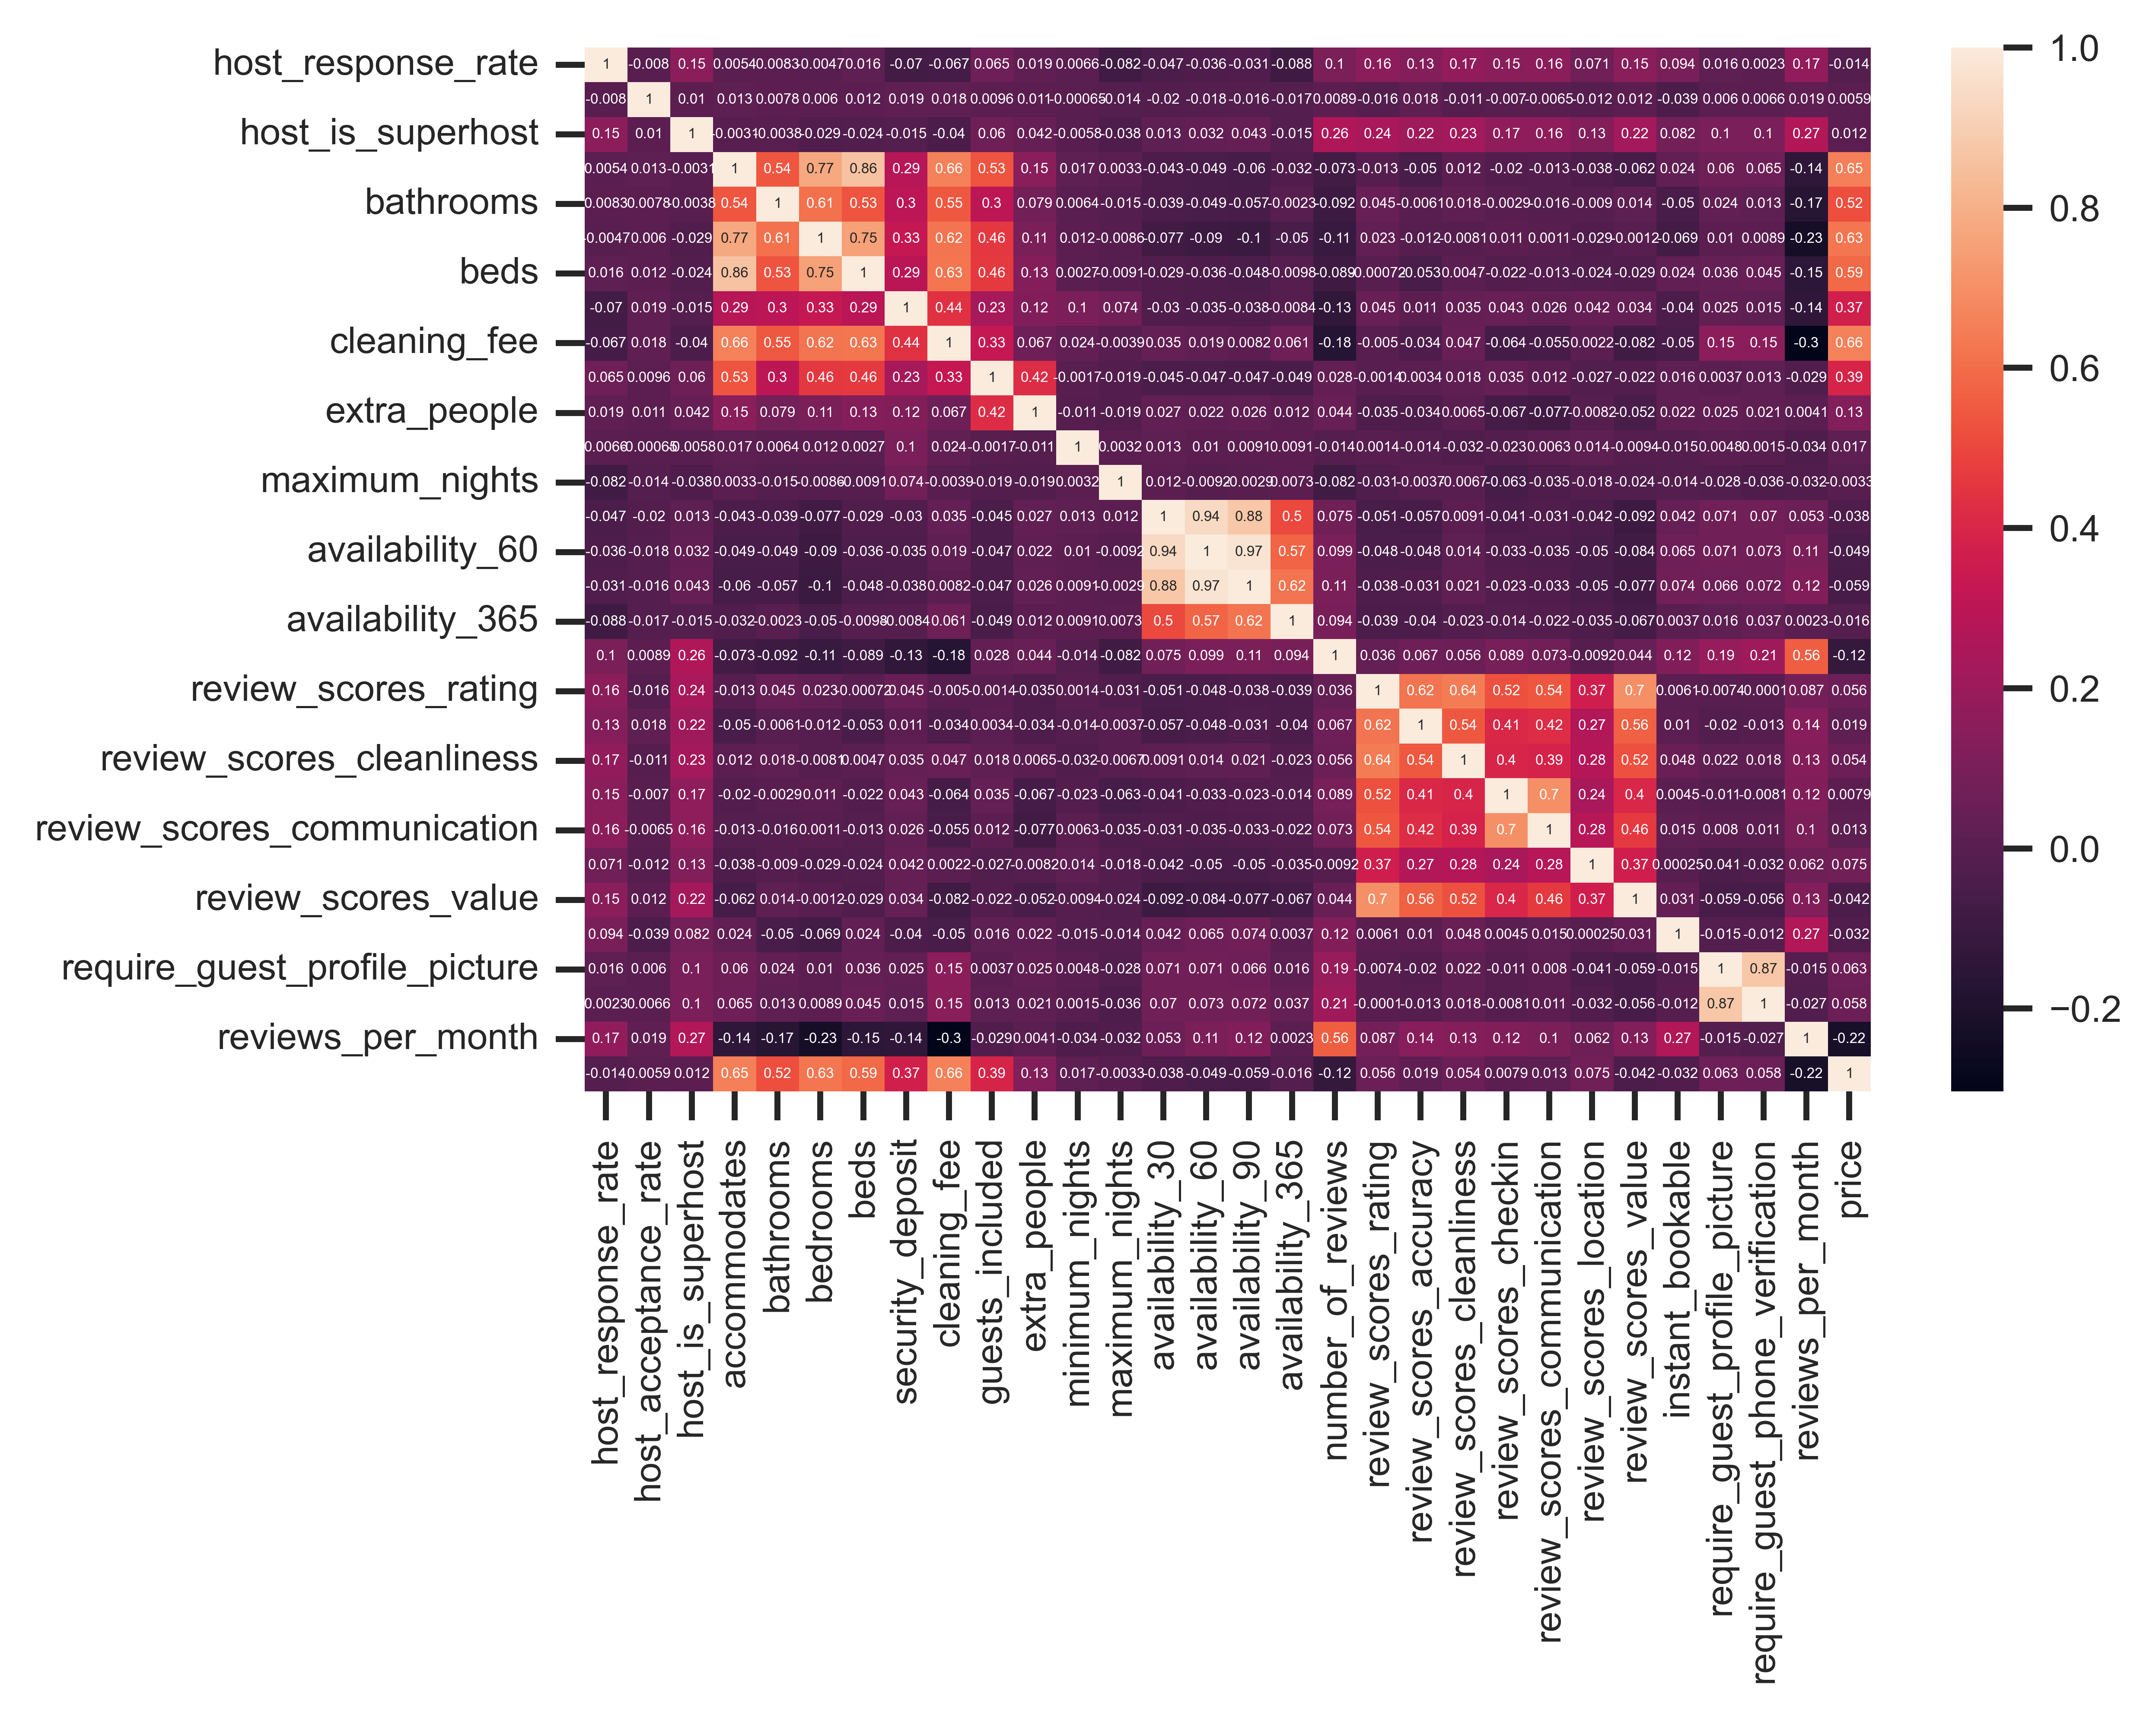

In [68]:
features = listings_metadata[(listings_metadata.ML == 1) | (listings_metadata.ML == 2)].Label.to_list() # Official & Possible ML features
features.append('price') # Add target
plt.figure(dpi=800)
sns.heatmap(listings[features].corr(), cmap="rocket", annot=True, annot_kws={"fontsize": 3});

#### Heatmap 2.0

Since Pandas .corr() only calculates the numeric data. I performed target encoding then drew the heatmap again.

room_type, neighbourhood_group_cleansed, bed_type, cancellation_policy were categorical data that cannot be calculated the correlation coefficient. But after target encoding, they do have a very high impact on price. For the amenities, TV, Hot Tub, Kitchen, Indoor Fireplace, Dryer, Family/Kid Friendly, Doorman, Gym, Cable TV, Washer, Air Conditioning are the more critical than other amenities.

All available amenities:

* 24-Hour Check-in
* Air Conditioning
* Breakfast
* Buzzer/Wireless Intercom
* Cable TV
* Carbon Monoxide Detector
* Cat(s)
* Dog(s)
* Doorman
* Dryer
* Elevator in Building
* Essentials
* Family/Kid Friendly
* Fire Extinguisher
* First Aid Kit
* Free Parking on Premises
* Gym
* Hair Dryer
* Hangers
* Heating
* Hot Tub
* Indoor Fireplace
* Internet
* Iron
* Kitchen
* Laptop Friendly Workspace
* Lock on Bedroom Door
* Other pet(s)
* Pets Allowed
* Pets live on this property
* Pool
* Safety Card
* Shampoo
* Smoke Detector
* Smoking Allowed
* Suitable for Events
* TV
* Washer
* Washer / Dryer
* Wheelchair Accessible
* Wireless Internet

In [69]:
def clean_corr(df, target, threshold):
    """Return df.corr() that greater or equal than threshold.
    
    Args:
        df (dataframe): Pandas dataframe.
        target (str): The name of target.
        threshold (float): The miniumu required correlation coefficient.
        
    Returns:
        df.corr()
    """
    df = df.corr().copy()
    
    for col in df.columns:
        if abs(df.loc[col, target]) < threshold:
            df.drop(col, axis=0, inplace=True)
            df.drop(col, axis=1, inplace=True)
    return df

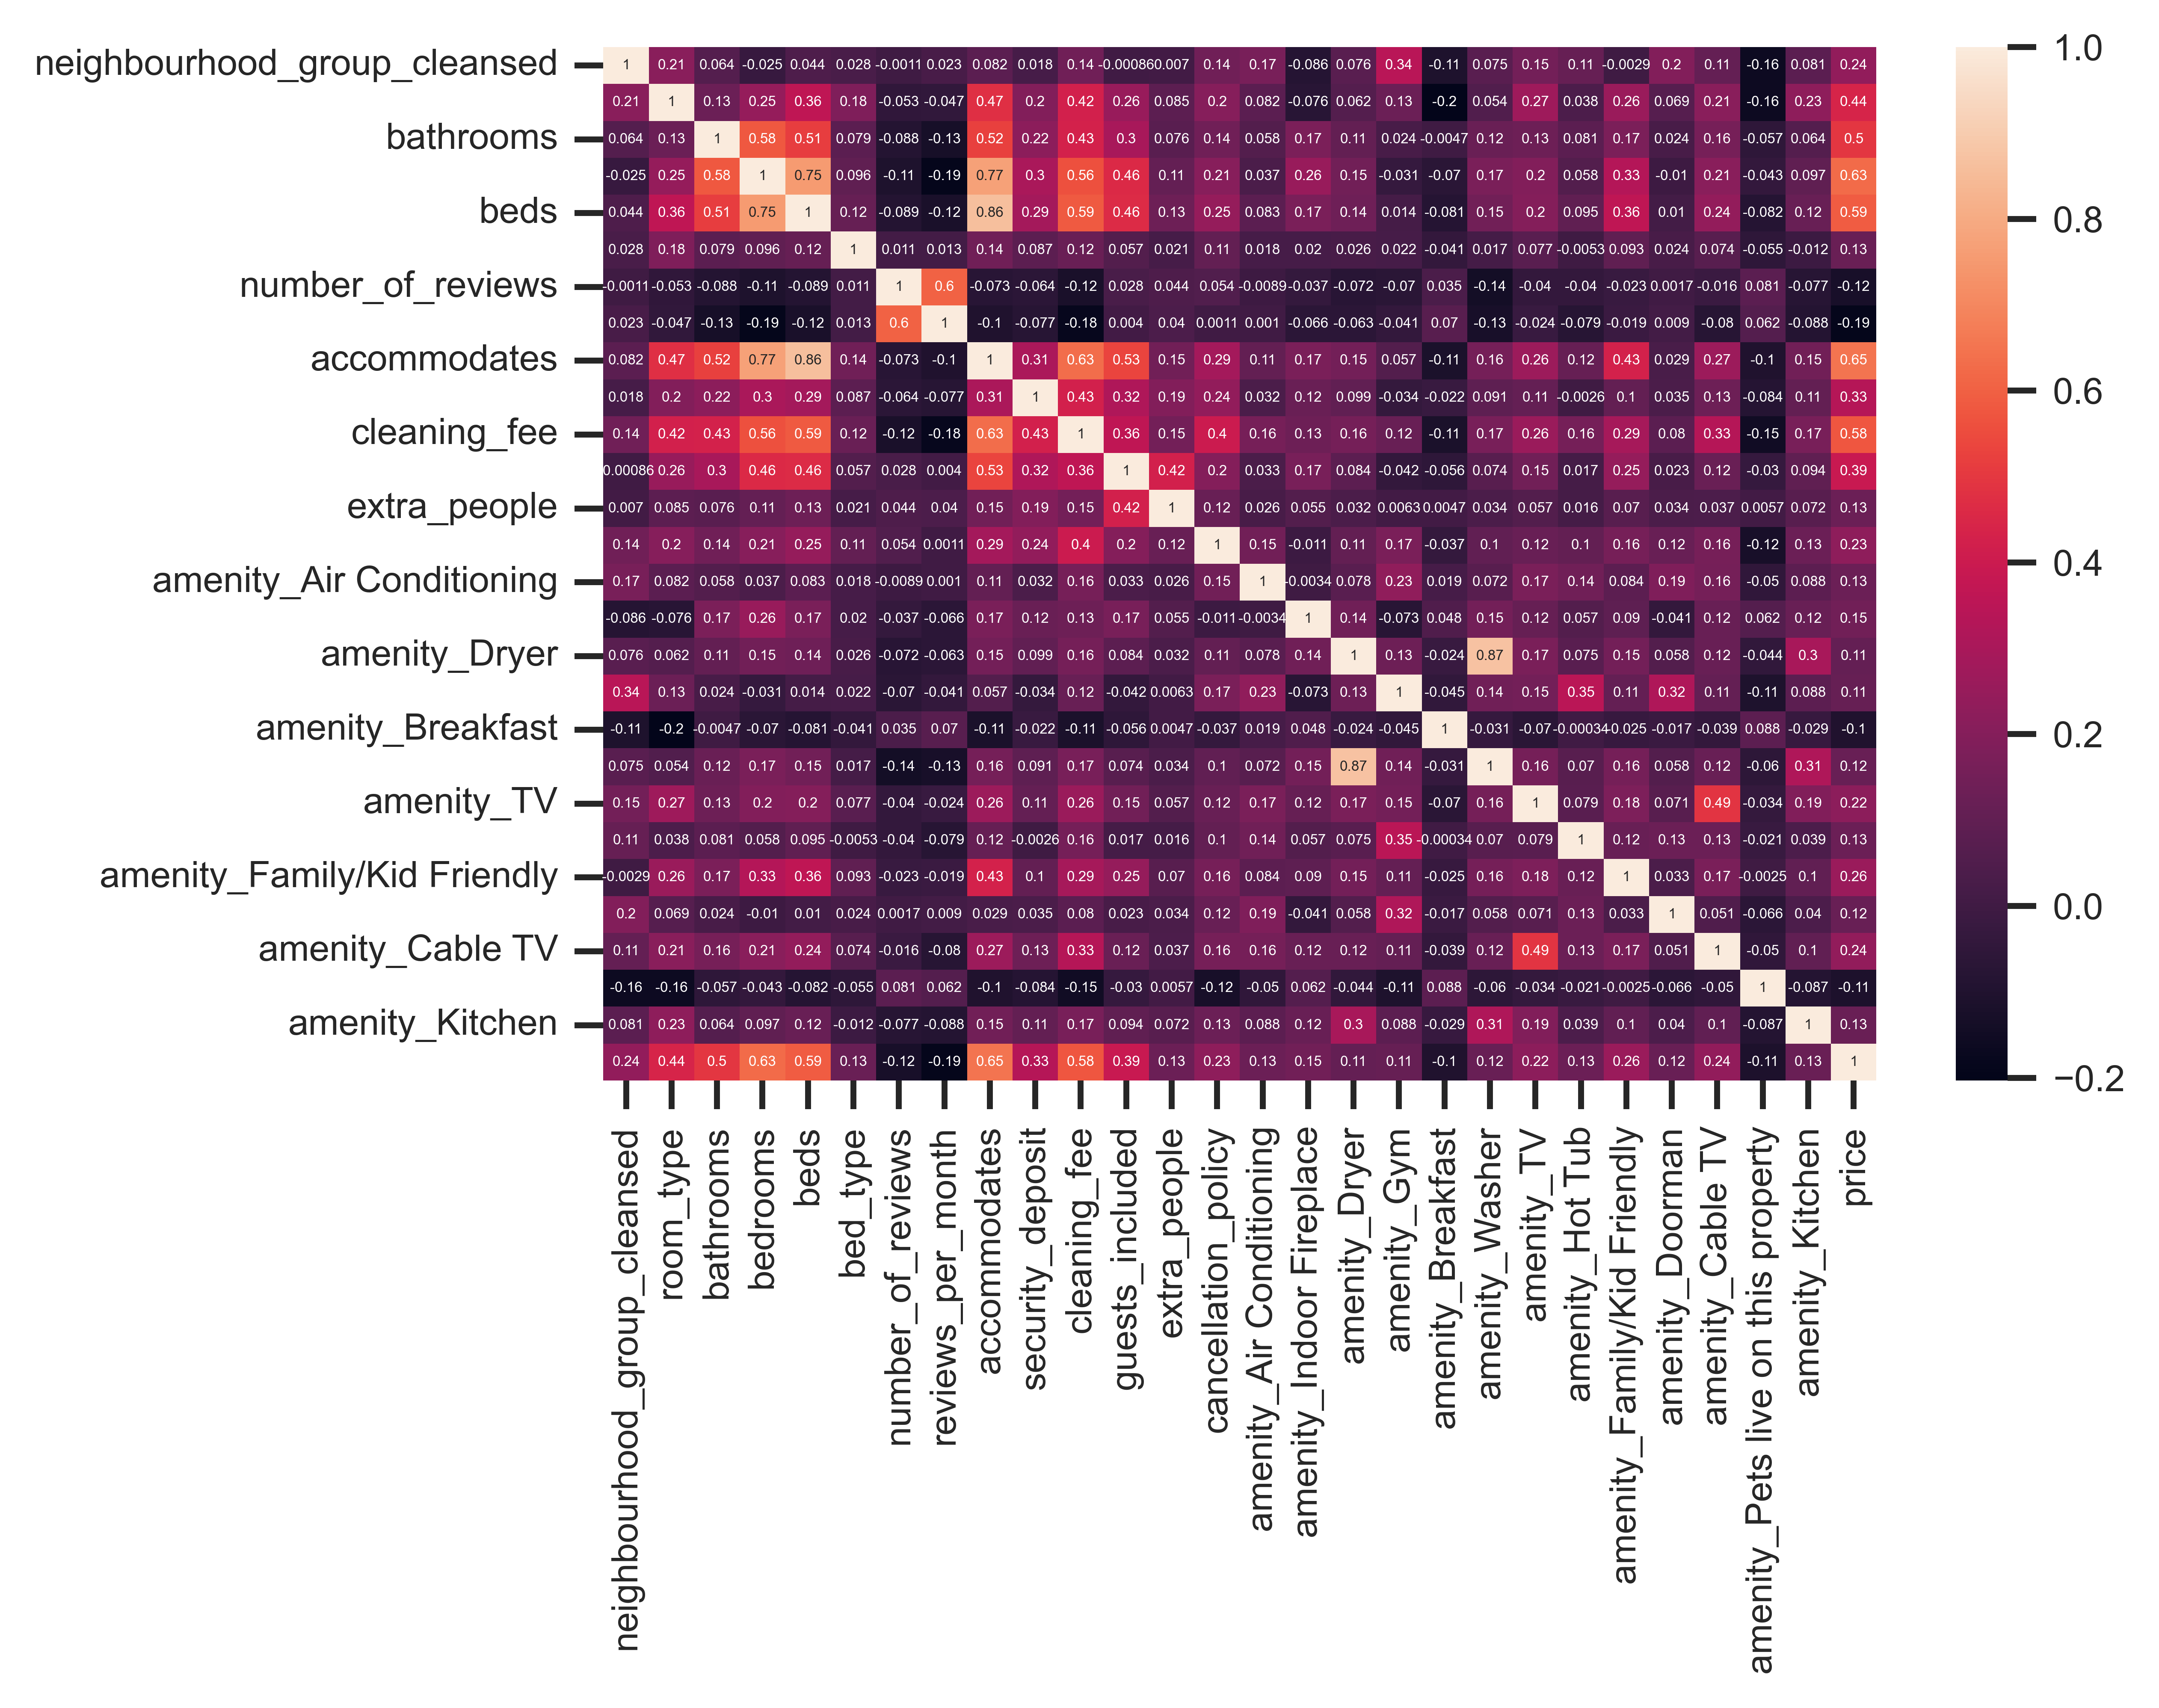

In [70]:
X_corr = clean_corr(X, 'price', 0.1)
plt.figure(dpi=800)
sns.heatmap(X_corr, cmap="rocket", annot=True, annot_kws={"fontsize": 3});

## Map

For more ideas, visualizations of all Seattle datasets can be found [Here, Inside Airbnb](http://insideairbnb.com/seattle/)

Reference: [Scatter Plots on Mapbox in Python](https://plotly.com/python/scattermapbox/#multiple-markers)

In [71]:
#px.set_mapbox_access_token(open(".mapbox_galaxy").read())
px.set_mapbox_access_token('pk.eyJ1IjoiemFja3NhbWJlciIsImEiOiJjazc3MXI1NjQwMXIzM25vMnBtMWtpNWFjIn0.FHxYZnEoStWmap8EQe2l-g')
fig = px.scatter_mapbox(listings, 
                        lat='latitude', 
                        lon='longitude',
                        color='neighbourhood_group_cleansed', 
                        size='price', 
                        color_continuous_scale=px.colors.cyclical.IceFire, 
                        hover_name='id',
                        hover_data=['listing_url', 'property_type', 'room_type'],
                        size_max=15, 
                        zoom=10,
                        title='Map of the Price Group by Neighbourhood_group_cleansed')
fig.show()

## Histograms

Take a glance at the following high correlation coefficient features: accommodates, bathrooms, bedrooms, beds, security_deposit, cleaning_fee, guests_included, extra_people, room_type, neighbourhood_group_cleansed, bed_type, cancellation_policy

#### Histogram 1.0

In [72]:
fig = px.histogram(listings.dropna(subset=['property_type'], axis=0), 
                   x='price', 
                   histnorm='percent',
                   color='property_type',
                   title='Histogram of Price Vs. Propery Type')
fig.show()

#### Histogram 2.0

In [73]:
fig = px.histogram(listings.dropna(subset=['room_type'], axis=0), 
                   x='price', 
                   histnorm='percent',
                   color='room_type',
                   title='Histogram of Price vVs. Room Type')
fig.show()

#### Histogram 3.0

In [74]:
fig = px.histogram(listings.dropna(subset=['beds'], axis=0), 
                   x='price', 
                   histnorm='percent',
                   color='beds', 
                   title='Histogram of Price Vs. (Number of Beds')
fig.show()

## Parallel Coordinates Plot
Reference: [Parallel Coordinates Plot in Python](https://anvilproject.org/guides/content/creating-links)

In [75]:
features = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'security_deposit', 'cleaning_fee', 
            'guests_included', 'extra_people', 'room_type', 'neighbourhood_group_cleansed', 
            'bed_type', 'cancellation_policy']
fig = px.parallel_coordinates(listings[features + ['price']].dropna(), color = "price",
                    color_continuous_scale = px.colors.diverging.Tealrose, color_continuous_midpoint = 2)
fig.show()

## Mutual Information

In [76]:
def make_mi_scores(X, y):
    X = X.copy()
    # Mutual Information required all data be integers
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize() # factorize() returns code and uniques
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [77]:
%%time
features = ['host_acceptance_rate', 'neighbourhood_group_cleansed', 'property_type', 'room_type',
            'bathrooms', 'bedrooms', 'beds', 'bed_type', 'number_of_reviews', 'review_scores_rating',
            'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
            'review_scores_location', 'review_scores_value', 'reviews_per_month', 'host_response_rate', 'host_is_superhost', 
            'accommodates', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 
            'maximum_nights', 'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', 
            'require_guest_phone_verification', 'amenities', 'demand', 'kfold']

X.drop(columns=['kfold', 'price'], inplace=True)

# Review the MI score from all data
all_mi_scores = pd.DataFrame(make_mi_scores(X, y))

all_mi_scores.style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

CPU times: total: 1.7 s
Wall time: 1.69 s


## Outliers and Real Demand
Reference: [Supply and demand](https://en.wikipedia.org/wiki/Supply_and_demand)

In [microeconomics](https://en.wikipedia.org/wiki/Microeconomics), supply and demand is an economic model of price determination in a market. The price P of a product is determined by a balance between production at each price (supply S) and the desires of those with purchasing power at each price (demand D). The diagram shows a positive shift in demand from  D1 to  D2, resulting in an increase in price (P) and quantity sold (Q) of the product. However, the booked listings and unavailable listings are both available = f in the dataset calendar. As I mentioned above, we don't have the transaction data. Therefore, I designed a simple but effective model to filter the booked listings. For example: listing [3402376](https://www.airbnb.com/rooms/3402376?source_impression_id=p3_1661615579_YG0yz0vIqyWJZApP) has 5 reviews in total (1st review was in Sep 2014) but available = 'f' for 365 days. As you can see, the listing was not booked by someone for a whole year. Instead, the host set the listing as unavailable for 365 days.

In [78]:
calendar

listing_id       date  available  price
0            241032 2016-01-04          1   85.0
1            241032 2016-01-05          1   85.0
2            241032 2016-01-06          0    NaN
3            241032 2016-01-07          0    NaN
4            241032 2016-01-08          0    NaN
...             ...        ...        ...    ...
1393565    10208623 2016-12-29          0    NaN
1393566    10208623 2016-12-30          0    NaN
1393567    10208623 2016-12-31          0    NaN
1393568    10208623 2017-01-01          0    NaN
1393569    10208623 2017-01-02          0    NaN

[1393570 rows x 4 columns]

In [79]:
# The calendar recorded the availability of each listing in the next 365 days
calendar.groupby('listing_id').size()

listing_id
3335        365
4291        365
5682        365
6606        365
7369        365
           ... 
10332096    365
10334184    365
10339144    365
10339145    365
10340165    365
Length: 3818, dtype: int64

In [80]:
# When the available is False, the price is NaN (Not a Number)
print(calendar.isna().sum())
print(calendar[calendar.available == 1].price.isna().sum())
print(calendar[calendar.available == 0].price.isna().sum())

listing_id         0
date               0
available          0
price         459028
dtype: int64
0
459028


As we mentioned earlier, we cannot know the real demand since we don't have transaction data and search engine data.
However, we can use a statistical method to filter the outliers.

- We extracted the unavailability for each listing in the next 365 days then divided it by 365. So the maximum unavailability_365 is 1, which means the listing was unavailable for a year or was booked by someone for a year; the minimum unavailability_365 is 0, which means the listing was ready for booking every day.
- We extracted the number of reviews for each listing started from the first view day and ended with 2016-01-04 (the scraped date). Then I calculated the number of reviews per day for each listing. Therefore, the maximum reviews_per_day is 1, which means the listing got reviews every day; the minimum reviews_per_day is 0, which means the listing never got any reviews.
- We can determine the threshold. But here I used unavailability_365 > 75% quantile and 0.010376 < 25% quantile as the filter to split the dataset into two parts.
- As we can see, the relative normal data in the calendar shows the intersections on the plot; However, the possible outliers have a wide border between reviews_per_day and unavailability_365.

In [81]:
# The possible outliers
eda_demand = EDA_demand()
demand = eda_demand.reviews_rate_vs_unavailability(365)
demand.describe()

unavailability_365_unscaled  unavailability_365     datediff  \
count                  3818.000000         3818.000000  3191.000000   
mean                    120.227344            0.329390   408.743027   
std                     126.772526            0.347322   402.669792   
min                       0.000000            0.000000     2.000000   
25%                       5.000000            0.013699   135.000000   
50%                      57.000000            0.156164   233.000000   
75%                     241.000000            0.660274   554.500000   
max                     365.000000            1.000000  2403.000000   

       reviews_per_day       demand  
count      3818.000000  3818.000000  
mean          0.060764    98.632006  
std           0.065355   113.641937  
min           0.000000     0.000000  
25%           0.010376     4.000000  
50%           0.038898    38.500000  
75%           0.092715   192.000000  
max           0.500000   365.000000

In [82]:
eda_demand.plot(outliers=False)

In [83]:
eda_demand.plot(outliers=True)